In [25]:

# paso 1 importamos todas las librerias

import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import io


In [26]:
# PASO 2 — Descargar el HTML con requests y guardarlo en una variable

# 1) El script define la URL de la página que se quiere scrapear
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"

# 2) El script usa un User-Agent para que la web lo trate como un navegador normal
headers = {"User-Agent": "Mozilla/5.0"}

# 3) El script hace la petición HTTP (como si fuera abrir la página en el navegador)
response = requests.get(url, headers=headers)

# 4) El script verifica si la petición salió bien (si no, lanza un error y se detiene)
response.raise_for_status()

# 5) El script guarda el contenido HTML (texto de la página) dentro de una variable
html = response.text

# 6) El script imprime una parte pequeña del HTML para confirmar que se descargó correctamente

print("Status code:", response.status_code)

Status code: 200


In [27]:
# PASO 3 — Analizar el HTML con BeautifulSoup para encontrar la estructura con los datos


# Extraer las tablas con pandas
html = io.StringIO(response.text)
tables = pd.read_html(html)
print(f"Se encontraron {len(tables)} tablas.")


# Inspeccionar la tabla (primer vistazo)
df = tables[0]          # cambia el índice si no es la tabla correcta
df.head()               # muestra las primeras 5 fila


Se encontraron 26 tablas.


,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,5.289,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.780,6 January 2017,[2]
2,3,"""Sweater Weather""",The Neighbourhood,4.397,3 December 2012,[3]
3,4,"""Starboy""",The Weeknd and Daft Punk,4.378,21 September 2016,[4]
4,5,"""As It Was""",Harry Styles,4.259,1 April 2022,[5]


In [28]:
#Paso 4: Procesa el DataFrame

# 1) Quitar filas totalmente vacías
df = df.dropna(how="all")

# 2) Eliminar filas que contengan "B" (como valor suelto) en cualquier columna
mask_b = df.astype(str).apply(lambda col: col.str.contains(r"\bB\b", na=False))
df = df[~mask_b.any(axis=1)]

# 3) Eliminar filas sin información (todas las celdas vacías o solo espacios)
df = df[df.astype(str).apply(lambda row: row.str.strip().ne("").any(), axis=1)]

# 4) Resetear índices
df = df.reset_index(drop=True)

print(df.head())


  Rank               Song                 Artist(s) Streams (billions)  \
0    1  "Blinding Lights"                The Weeknd              5.289   
1    2     "Shape of You"                Ed Sheeran              4.780   
2    3  "Sweater Weather"         The Neighbourhood              4.397   
3    4          "Starboy"  The Weeknd and Daft Punk              4.378   
4    5        "As It Was"              Harry Styles              4.259   

        Release date Ref.  
0   29 November 2019  [1]  
1     6 January 2017  [2]  
2    3 December 2012  [3]  
3  21 September 2016  [4]  
4       1 April 2022  [5]  


In [29]:
# PASO 5 — Crear la base de datos
conn = sqlite3.connect("spotify_top_songs.db")

#  — Crear/reescribir la tabla e insertar el DataFrame
df.to_sql("most_streamed", conn, if_exists="replace", index=False)

#  — Comprobar cuántas filas se insertaron
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM most_streamed")
print("Rows inserted:", cursor.fetchone()[0])

# — Guardar cambios y cerrar
conn.commit()
conn.close()


Rows inserted: 101


In [30]:
# PASO 6 — Visualiza los datos (Codespaces: guardar gráficos como PNG)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear carpeta outputs si no existe
import os
os.makedirs("outputs", exist_ok=True)

# 1) Asegurar que Streams sea numérico
df["Streams (billions)"] = pd.to_numeric(
    df["Streams (billions)"].astype(str).str.replace(",", "", regex=False),
    errors="coerce"
)


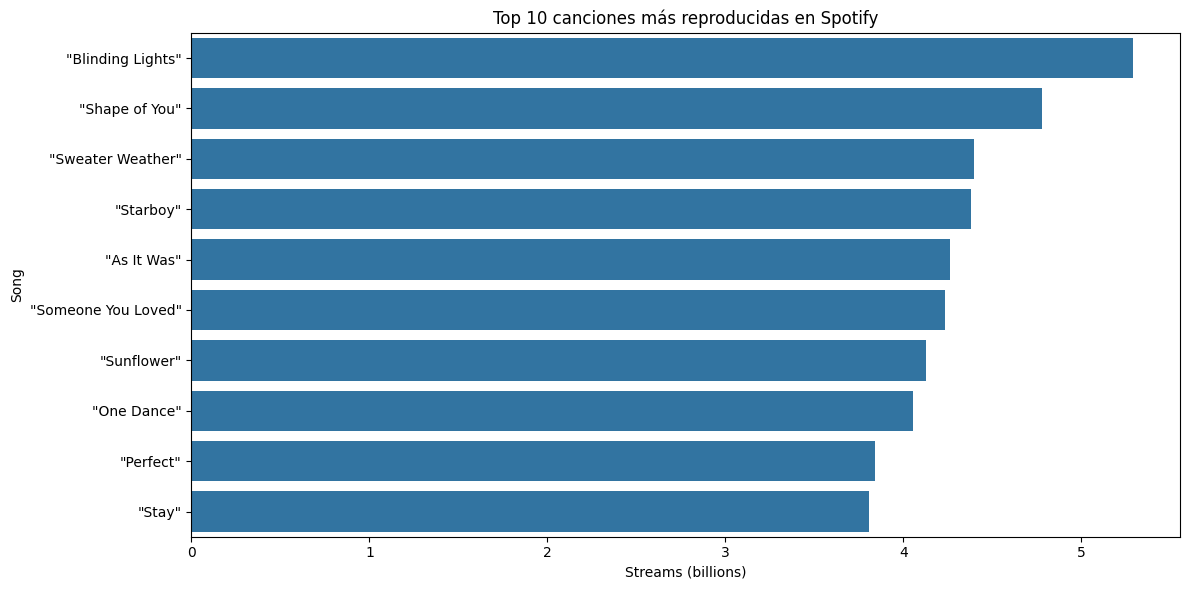

In [31]:
# ---------------- Gráfico 1: Top 10 canciones por streams ----------------
top10 = df.dropna(subset=["Streams (billions)"]).nlargest(10, "Streams (billions)")

plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="Streams (billions)", y="Song")
plt.title("Top 10 canciones más reproducidas en Spotify")
plt.xlabel("Streams (billions)")
plt.ylabel("Song")
plt.tight_layout()
plt.savefig("outputs/grafico1_top10.png", dpi=200, bbox_inches="tight")
plt.show()


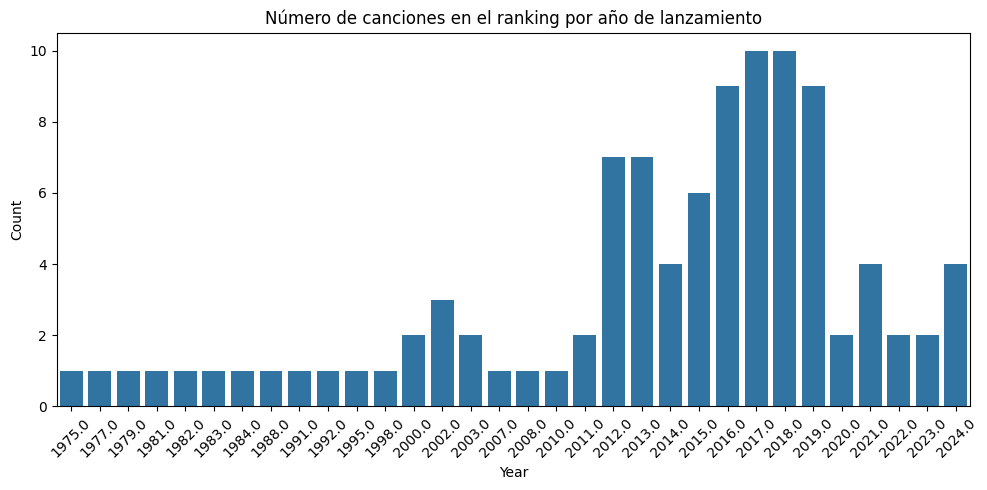

In [32]:
# ---------------- Gráfico 2: Número de canciones por año de lanzamiento ----------------
df["Release date"] = pd.to_datetime(df["Release date"], errors="coerce")
df["Year"] = df["Release date"].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(
    data=df.dropna(subset=["Year"]),
    x="Year",
    order=sorted(df["Year"].dropna().unique())
)
plt.title("Número de canciones en el ranking por año de lanzamiento")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/grafico2_por_anio.png", dpi=200, bbox_inches="tight")
plt.show()

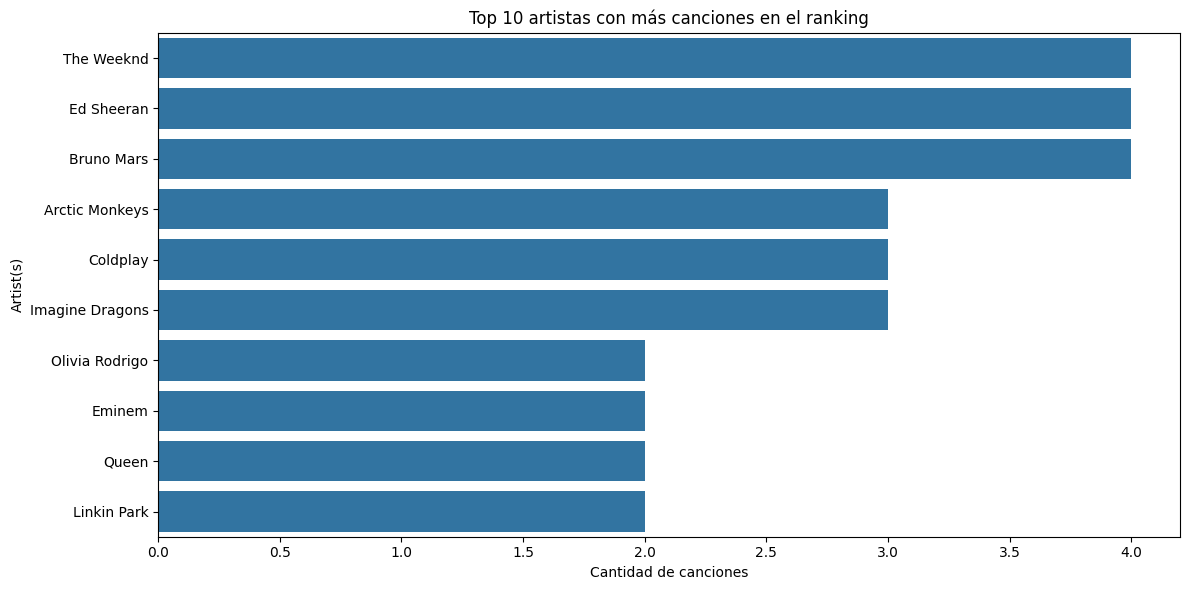

In [33]:
# ---------------- Gráfico 3: Top 10 artistas con más canciones en el ranking ----------------
top_artists = df["Artist(s)"].astype(str).value_counts().head(10).reset_index()
top_artists.columns = ["Artist(s)", "Count"]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_artists, x="Count", y="Artist(s)")
plt.title("Top 10 artistas con más canciones en el ranking")
plt.xlabel("Cantidad de canciones")
plt.ylabel("Artist(s)")
plt.tight_layout()
plt.savefig("outputs/grafico3_top_artistas.png", dpi=200, bbox_inches="tight")
plt.show()
